In [12]:
# source https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/

In [133]:
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /data/home/spushkov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [139]:
movies_with_img_path = pd.read_csv('./our_data/each_genre200.csv')

In [135]:
movies_with_img_path.head(3)

,imdb_title_id,img_path,title,first_genre,description
0,tt0119863,./Poster/1997/tt0119863/tt0119863.jpg,Le pari,Comedy,"Deux beaux-frères, Didier et Bernard se lancen..."
1,tt0959306,./Poster/2014/tt0959306/tt0959306.jpg,Reach Me - La strada per il successo,Comedy,A self-help book changes the lives of differen...
2,tt0094921,./Poster/1988/tt0094921/tt0094921.jpg,Dall'altro lato della strada,Comedy,A Manhattan single meets a man through her Jew...


In [136]:
# function for text cleaning 
def preproc_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

## Filter out records with no description

In [140]:
movies_with_img_path[movies_with_img_path.isna().any(axis=1)]

,imdb_title_id,img_path,title,first_genre,description


In [164]:
movies_with_img_path['preproc_description'] = movies_with_img_path['description'].apply(lambda x: preproc_text(x))

In [165]:
movies_with_img_path

,imdb_title_id,img_path,title,first_genre,description,preproc_description,genre_encoded
0,tt0119863,./Poster/1997/tt0119863/tt0119863.jpg,Le pari,Comedy,"Deux beaux-frères, Didier et Bernard se lancen...",deux beaux fr res didier et bernard se lancent...,4
1,tt0959306,./Poster/2014/tt0959306/tt0959306.jpg,Reach Me - La strada per il successo,Comedy,A self-help book changes the lives of differen...,a self help book changes the lives of differen...,4
2,tt0094921,./Poster/1988/tt0094921/tt0094921.jpg,Dall'altro lato della strada,Comedy,A Manhattan single meets a man through her Jew...,a manhattan single meets a man through her jew...,4
3,tt0061495,./Poster/1967/tt0061495/tt0061495.jpg,La collezionista,Comedy,A womanizing art dealer and a painter find the...,a womanizing art dealer and a painter find the...,4
4,tt0083833,./Poster/1982/tt0083833/tt0083833.jpg,A cena con gli amici,Comedy,A group of college-age buddies struggle with t...,a group of college age buddies struggle with t...,4
...,...,...,...,...,...,...,...
3214,tt0043251,./Poster/1951/tt0043251/tt0043251.jpg,La penna rossa,Film-Noir,Respectable citizens receive anonymous letters...,respectable citizens receive anonymous letters...,9
3215,tt0045205,./Poster/1952/tt0045205/tt0045205.jpg,So che mi ucciderai,Film-Noir,After an ambitious actor insinuates himself in...,after an ambitious actor insinuates himself in...,9
3216,tt0046126,./Poster/1953/tt0046126/tt0046126.jpg,Niagara,Film-Noir,"As two couples are visiting Niagara Falls, ten...",as two couples are visiting niagara falls tens...,9
3217,tt0047976,./Poster/1955/tt0047976/tt0047976.jpg,Dementia,Film-Noir,"This film, with no dialogue at all, follows a ...",this film with no dialogue at all follows a ps...,9


## Remove stop-words

In [166]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_with_img_path['preproc_description'] = movies_with_img_path['preproc_description'].apply(lambda x: remove_stopwords(x))

In [167]:
movies_with_img_path

,imdb_title_id,img_path,title,first_genre,description,preproc_description,genre_encoded
0,tt0119863,./Poster/1997/tt0119863/tt0119863.jpg,Le pari,Comedy,"Deux beaux-frères, Didier et Bernard se lancen...",deux beaux fr res didier et bernard se lancent...,4
1,tt0959306,./Poster/2014/tt0959306/tt0959306.jpg,Reach Me - La strada per il successo,Comedy,A self-help book changes the lives of differen...,self help book changes lives different people ...,4
2,tt0094921,./Poster/1988/tt0094921/tt0094921.jpg,Dall'altro lato della strada,Comedy,A Manhattan single meets a man through her Jew...,manhattan single meets man jewish grandmothers...,4
3,tt0061495,./Poster/1967/tt0061495/tt0061495.jpg,La collezionista,Comedy,A womanizing art dealer and a painter find the...,womanizing art dealer painter find serenity ri...,4
4,tt0083833,./Poster/1982/tt0083833/tt0083833.jpg,A cena con gli amici,Comedy,A group of college-age buddies struggle with t...,group college age buddies struggle imminent pa...,4
...,...,...,...,...,...,...,...
3214,tt0043251,./Poster/1951/tt0043251/tt0043251.jpg,La penna rossa,Film-Noir,Respectable citizens receive anonymous letters...,respectable citizens receive anonymous letters...,9
3215,tt0045205,./Poster/1952/tt0045205/tt0045205.jpg,So che mi ucciderai,Film-Noir,After an ambitious actor insinuates himself in...,ambitious actor insinuates life wealthy middle...,9
3216,tt0046126,./Poster/1953/tt0046126/tt0046126.jpg,Niagara,Film-Noir,"As two couples are visiting Niagara Falls, ten...",two couples visiting niagara falls tensions on...,9
3217,tt0047976,./Poster/1955/tt0047976/tt0047976.jpg,Dementia,Film-Noir,"This film, with no dialogue at all, follows a ...",film dialogue follows psychotic young womans n...,9


In [149]:
movies_with_img_path['first_genre'].value_counts()

Comedy       200
Drama        200
Action       200
Crime        200
Horror       200
Adventure    200
Animation    200
Biography    200
Thriller     200
Fantasy      200
Superhero    200
Western      191
Mystery      167
Romance      144
Sport        127
Family       124
Sci-Fi       107
Musical       71
War           27
Music         24
History       19
Film-Noir     18
Name: first_genre, dtype: int64

## Get X and y 

In [151]:
import numpy as np
np.random.seed(42)

In [168]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(movies_with_img_path['first_genre'])
movies_with_img_path['genre_encoded'] = le.transform(movies_with_img_path['first_genre'])
movies_with_img_path.preproc_description_split = movies_with_img_path.preproc_description.apply(lambda x: x.split(' '))

# X_train, X_val, y_train, y_val = train_test_split(movies_with_img_path.img_path.values, movies_with_img_path.genre_encoded.values, test_size=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(movies_with_img_path.preproc_description_split.values, movies_with_img_path.genre_encoded.values, test_size=0.10, random_state=42, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42, shuffle=True)

/tmp/ipykernel_1128755/3594713709.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  movies_with_img_path.preproc_description_split = movies_with_img_path.preproc_description.apply(lambda x: x.split(' '))


In [250]:

from gensim.models import Word2Vec
model = Word2Vec(sentences=movies_with_img_path.preproc_description_split.values, vector_size=12, window=5, min_count=1, workers=4)


In [264]:
corpus_emb = []
for sent in X_train:
    sent_emb = [model.wv[w] for w in sent]
    corpus_emb.append(np.array(sent_emb).sum(0))

In [265]:
train_emb_and_label = pd.concat([pd.DataFrame(np.array(corpus_emb)), pd.DataFrame(y_train, columns=['label'])], axis=1)

In [266]:
train_emb_and_label

,0,1,2,3,4,5,6,7,8,9,10,11,label
0,0.051308,-0.935837,-0.594364,-0.177173,-0.272797,0.260379,0.029612,0.473395,0.892076,-0.744305,2.845666,0.253005,2
1,0.251970,-0.242669,-0.431250,-0.177244,-0.297444,-0.154591,-0.033061,0.199795,0.594544,-0.397828,2.077050,0.310107,11
2,0.564196,-1.253201,-0.641893,-0.283181,-0.600685,-0.200387,-0.058485,0.794797,1.412354,-0.894844,3.988903,0.790709,6
3,0.677055,-1.706528,-1.084689,-1.181143,-0.886168,-0.241489,-0.482491,0.939689,1.978616,-1.147446,5.967331,0.688993,17
4,0.174688,-0.873871,-0.726376,-0.464400,-0.718888,-0.271593,-0.305783,0.328049,1.045719,-1.012190,2.965110,0.396094,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2892,0.568825,-0.892349,-1.069495,-0.422469,-0.275203,-0.320220,-0.289326,0.680728,1.497603,-1.057302,4.544978,0.780390,1
2893,0.143741,-1.283728,-0.787150,-0.374820,-0.146056,-0.390567,-0.196917,0.784410,1.027060,-0.925447,4.305999,0.740710,1
2894,0.498194,-1.746795,-1.196391,-0.808664,-0.573182,0.073743,-0.395967,0.981019,1.344577,-1.049212,5.408130,0.732659,2
2895,0.321313,-0.960461,-1.179005,-0.539814,-0.386105,-0.168705,-0.421048,0.723687,1.291299,-0.883215,4.946406,0.461287,11


In [267]:
corpus_emb_test = []
for sent in X_test:
    sent_emb = [model.wv[w] for w in sent]
    corpus_emb_test.append(np.array(sent_emb).sum(0))
    
test_emb_and_label = pd.concat([pd.DataFrame(np.array(corpus_emb_test)), pd.DataFrame(y_test, columns=['label'])], axis=1)

In [268]:
train_emb_and_label['label'] = le.inverse_transform(train_emb_and_label['label'].values)
test_emb_and_label['label'] = le.inverse_transform(test_emb_and_label['label'].values)

In [269]:
#Fit Logistic Regression model:
lr = LogisticRegression(multi_class='multinomial').fit(train_emb_and_label.drop('label', axis=1), train_emb_and_label['label'])


/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [270]:

labels = test_emb_and_label['label'].value_counts().index

In [271]:
y_pred = lr.predict(test_emb_and_label.drop(['label'], axis=1))
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(test_emb_and_label['label'].values, y_pred, labels=labels)


In [272]:
labels

Index(['Comedy', 'Drama', 'Action', 'Adventure', 'Biography', 'Animation',
       'Crime', 'Western', 'Thriller', 'Mystery', 'Fantasy', 'Horror',
       'Family', 'Superhero', 'Romance', 'Sci-Fi', 'Musical', 'Sport', 'War',
       'Film-Noir', 'Music', 'History'],
      dtype='object')

In [273]:
cm_df = pd.DataFrame(cm, index = labels, columns = labels)


In [274]:
cm_df

,Comedy,Drama,Action,Adventure,Biography,Animation,Crime,Western,Thriller,Mystery,...,Family,Superhero,Romance,Sci-Fi,Musical,Sport,War,Film-Noir,Music,History
Comedy,1,1,0,2,7,3,1,5,3,0,...,0,2,1,0,0,2,0,0,0,0
Drama,0,2,2,0,4,2,1,6,1,0,...,0,6,1,0,0,1,0,0,0,0
Action,0,2,1,2,5,2,0,2,2,1,...,0,1,0,0,0,0,0,0,0,0
Adventure,0,2,0,2,5,0,0,4,1,0,...,0,5,0,0,0,0,0,0,0,0
Biography,0,1,0,1,11,0,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0
Animation,0,6,0,0,7,2,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
Crime,0,4,0,0,4,2,0,3,3,0,...,0,2,0,1,0,1,0,0,0,0
Western,0,1,0,0,2,0,2,1,2,1,...,0,2,0,1,0,2,0,0,0,0
Thriller,0,3,0,0,3,2,3,2,2,0,...,0,2,0,0,0,0,0,0,0,0
Mystery,0,1,1,1,3,4,1,1,3,0,...,0,1,0,0,0,0,0,0,0,0


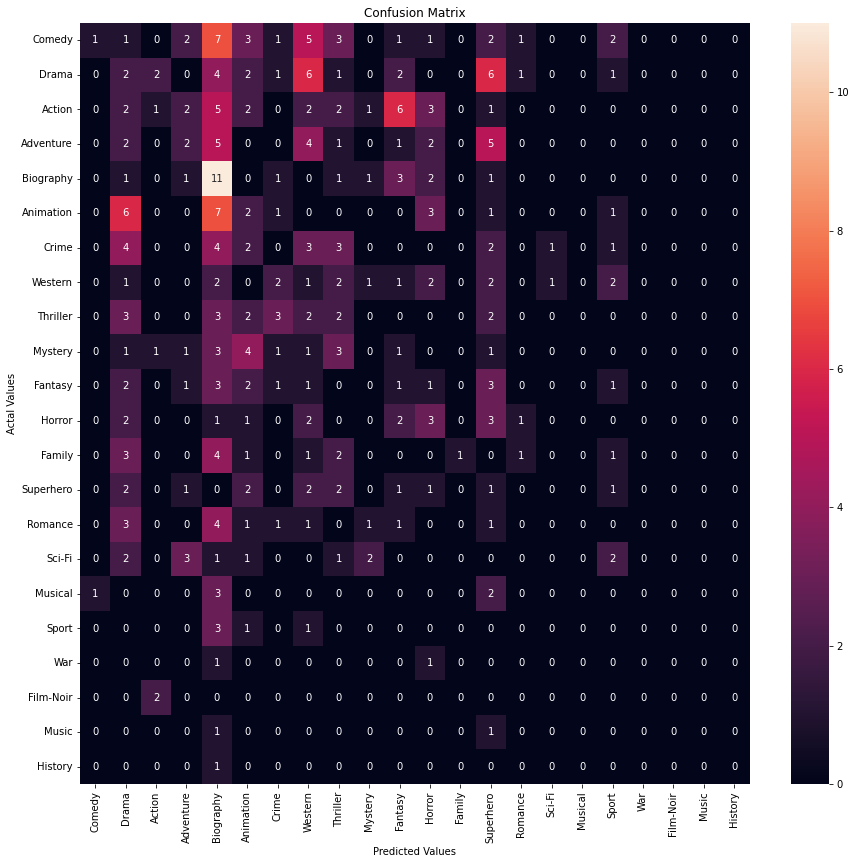

In [275]:
#Plotting the confusion matrix
plt.figure(figsize=(15,14))
sns.heatmap(cm_df, annot=True, fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [109]:
from sklearn.metrics import roc_auc_score

# Generate membership scores with .predict_proba
y_pred_probs = lr.predict_proba(X_val_tfidf)

# Calculate ROC_AUC
roc_auc = roc_auc_score(
    y_val, y_pred_probs, multi_class="ovr", average="weighted"
  )

In [110]:
roc_auc

0.8098617241299929